In [14]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Let's pull in the champions stats saved from the API

In [15]:
champ_stats = pd.read_csv('champ_stats.csv', index_col=0)

In [16]:
champ_stats.columns

Index(['hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor',
       'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange',
       'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit',
       'critperlevel', 'attackdamage', 'attackdamageperlevel',
       'attackspeedperlevel', 'attackspeed', 'tags', 'partype'],
      dtype='object')

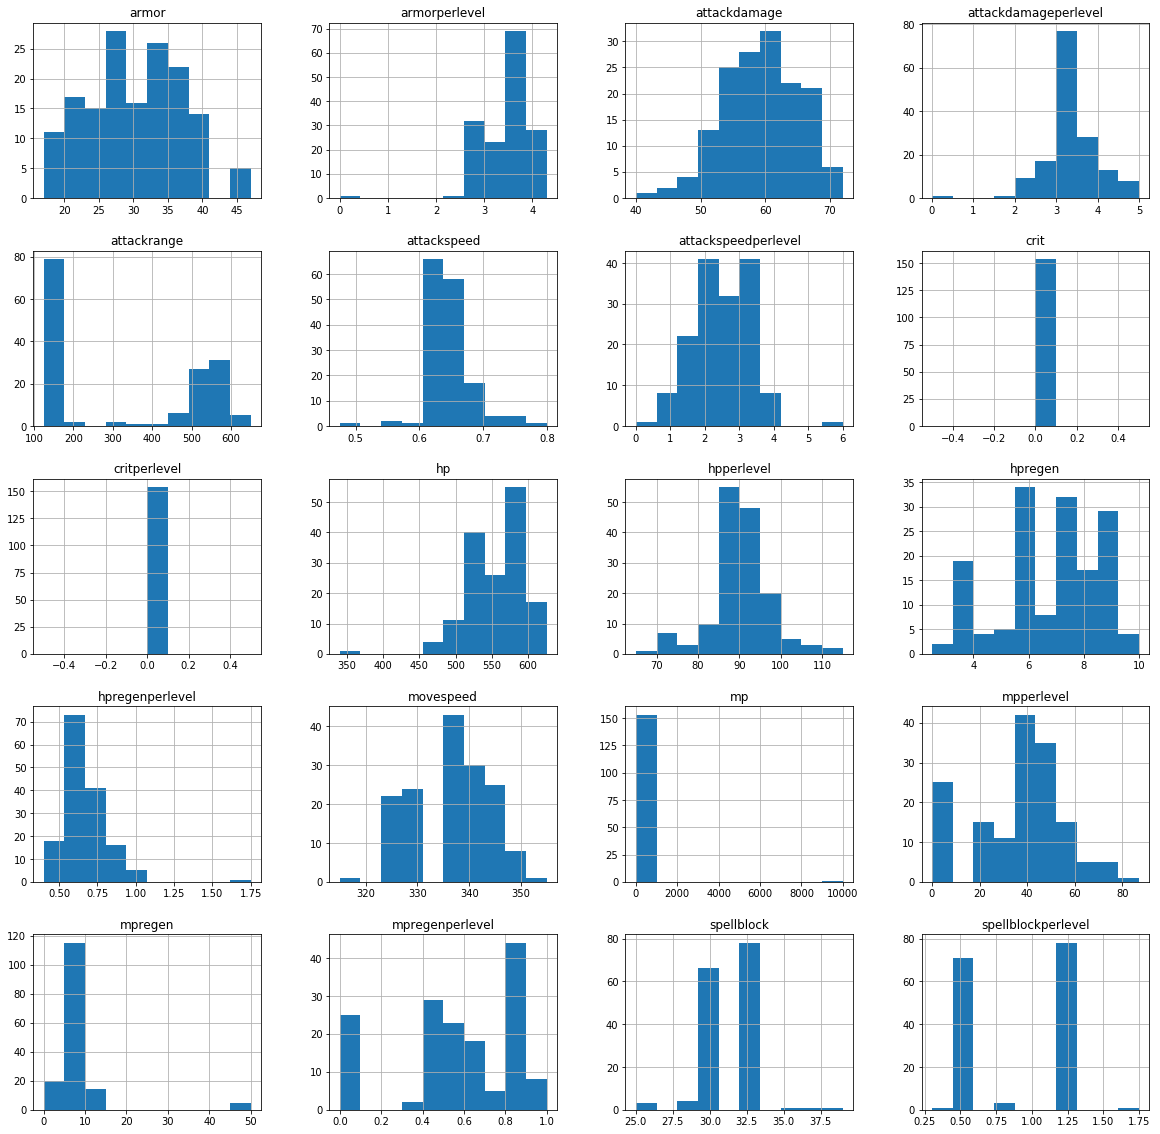

In [17]:
champ_stats.hist(figsize=(20,20))
plt.savefig('histogram', bbox_inches = 'tight')
plt.show()

There seems to be a good spread for most of the base stats. As we will see throughout our analysis, there are some general rules in League, but there is always an exception to the rule so we will see outliers one each plot.

After seeing a near normal distribution on several of the base stats and their corresponding scaler (ie armor and armorperlevel), my expectation is that those champions with high base values would also scale the best. To put another way, if a champion has high armor at level 1, they would likely have high armor at level 18 (the maximum level in the game). 

In [18]:
# Clean up the class column so we can work with just the primary class

champ_stats['tags'] = champ_stats['tags'].str.replace("'", '') #remove the single quotes from the column
new = champ_stats['tags'].str.lstrip('[+-]').str.rstrip(']').str.split(', ', expand=True) #make a new with the split tags so that we get both classes

# making separate first class column from new data frame
champ_stats['Primary Class']= new[0]
# making separate second class column from new data frame
champ_stats['Secondary Class']= new[1]
champ_stats.drop(columns=['tags'], inplace=True) #dropping the old column
# champ_stats #uncomment to view our dataframe

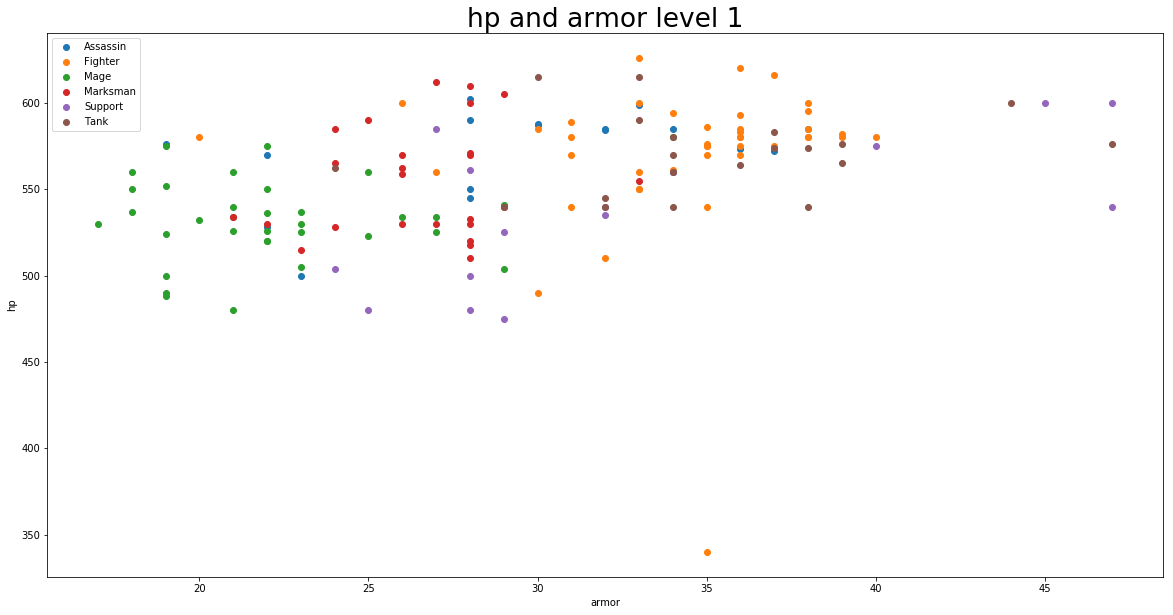

In [19]:
# Plot the hp and armour at level 1

fig = plt.figure(figsize=(20, 10))
groups = champ_stats.groupby('Primary Class')
for name, group in groups:
    plt.plot(group['armor'], group['hp'], marker="o", linestyle="", label=name)
plt.legend()
plt.rc('font', size=22) 
plt.title('hp and armor level 1')
plt.ylabel('hp')
plt.xlabel('armor')
plt.savefig('hp and armour lvl 1', bbox_inches = 'tight')
plt.show()

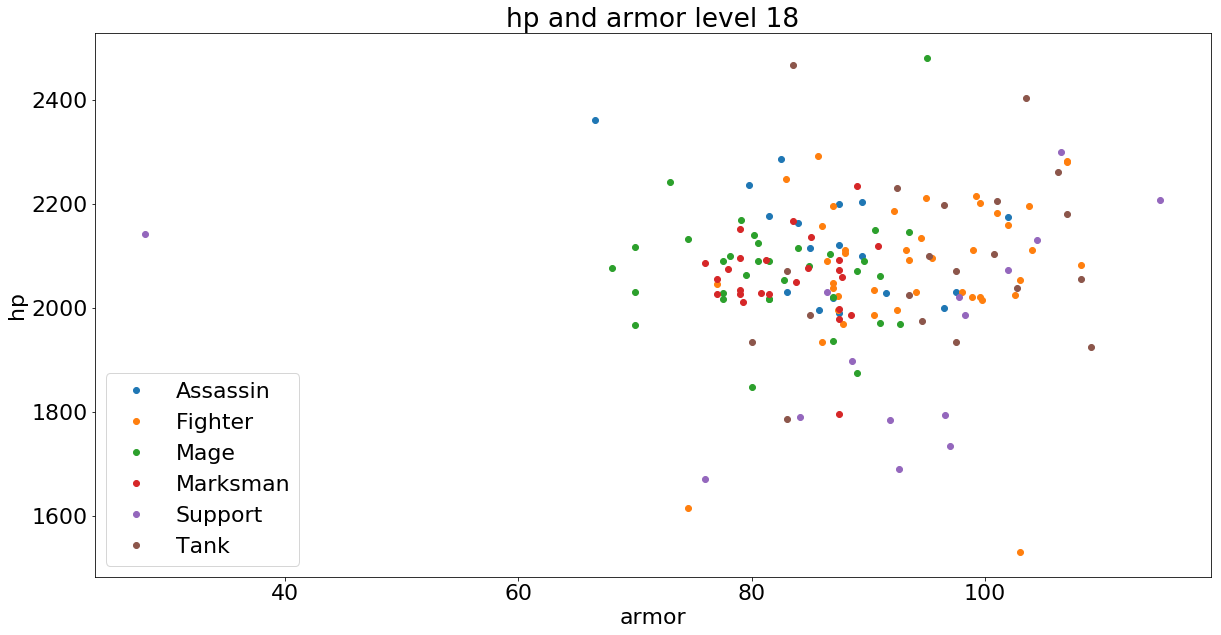

In [20]:
# Plot the hp and armour at the max level 18

fig = plt.figure(figsize=(20, 10))
groups = champ_stats.groupby('Primary Class')
for name, group in groups:
    plt.plot(group['armor']+(group['armorperlevel']*17), group['hp']+(group['hpperlevel']*17), marker="o", linestyle="", label=name)
plt.legend()
plt.title('hp and armor level 18')
plt.ylabel('hp')
plt.xlabel('armor')
plt.savefig('hp and armour lvl 18', bbox_inches = 'tight')
plt.show()

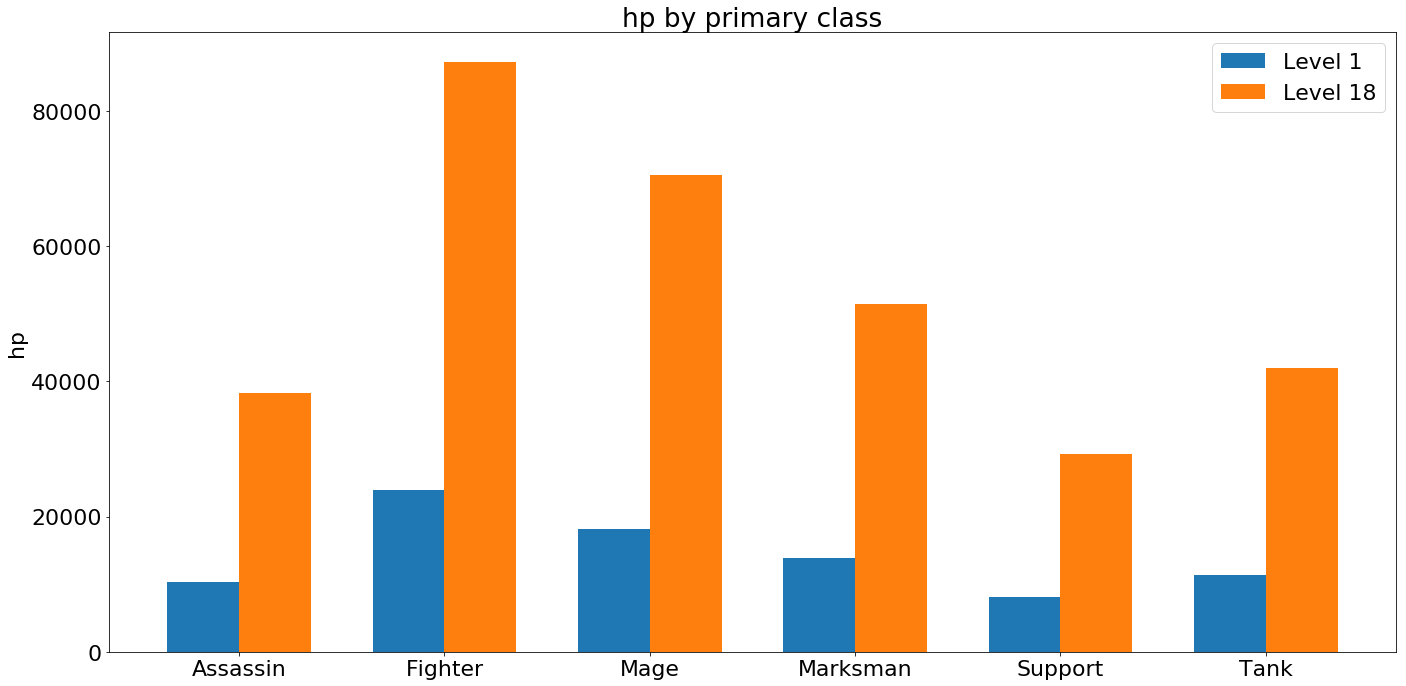

In [22]:
# not included in the blog but left here for interest, we take a look at the hp at level 1 and level 18 for each class

lvl1_hpsum = groups['hp'].sum()
lvl18_hpsum = groups['hp'].sum()+groups['hpperlevel'].sum()*17
labels = groups['hp'].sum().index

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, lvl1_hpsum, width, label='Level 1')
rects2 = ax.bar(x + width/2, lvl18_hpsum, width, label='Level 18')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('hp')
ax.set_title('hp by primary class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## Effective HP

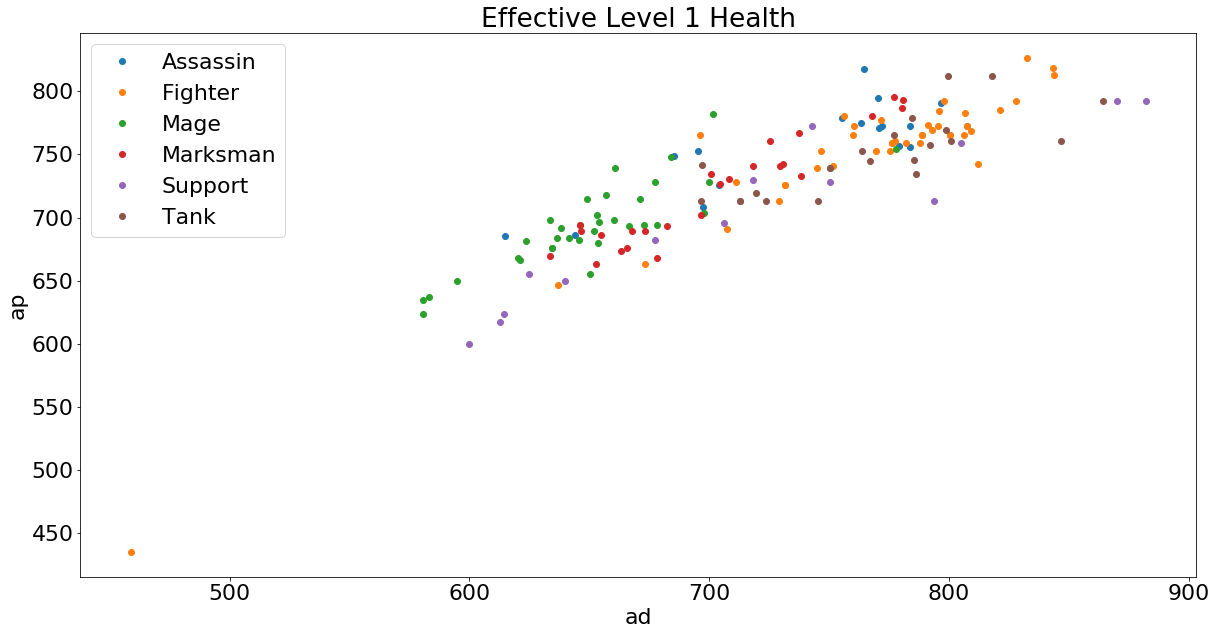

In [23]:
# Calculating and plotting effective AD and AP hp

champ_stats['Effective AD HP'] =  champ_stats['hp']*(1 + 0.01 * champ_stats['armor'])
champ_stats['Effective AP HP'] =  champ_stats['hp']*(1 + 0.01 * champ_stats['spellblock'])
fig = plt.figure(figsize=(20, 10))
# plt.scatter(ad_eff_hp, ap_eff_hp)
groups = champ_stats.groupby('Primary Class')
    
for name, group in groups:
    plt.plot(group['Effective AD HP'], group['Effective AP HP'], marker="o", linestyle="", label=name)
#     encircle(group['Effective AD HP'], group['Effective AP HP'], alpha=0.2))
    
plt.title('Effective Level 1 Health')
plt.ylabel('ap')
plt.xlabel('ad')
plt.legend()
plt.savefig('Effective Level 1 Health', bbox_inches = 'tight')
plt.show()

In [24]:
# Setting up effective hp differently so we can visualize and sort easier

rows = []
for prim_class in champ_stats['Primary Class'].unique():
    eff_ad_hp = champ_stats['Effective AD HP'][champ_stats['Primary Class']==prim_class].mean()
    eff_ap_hp = champ_stats['Effective AP HP'][champ_stats['Primary Class']==prim_class].mean()
    rows.append([eff_ad_hp, eff_ap_hp])
class_stats = pd.DataFrame(rows, columns=['Effective AD HP', 'Effective AP HP'], index=champ_stats['Primary Class'].unique())

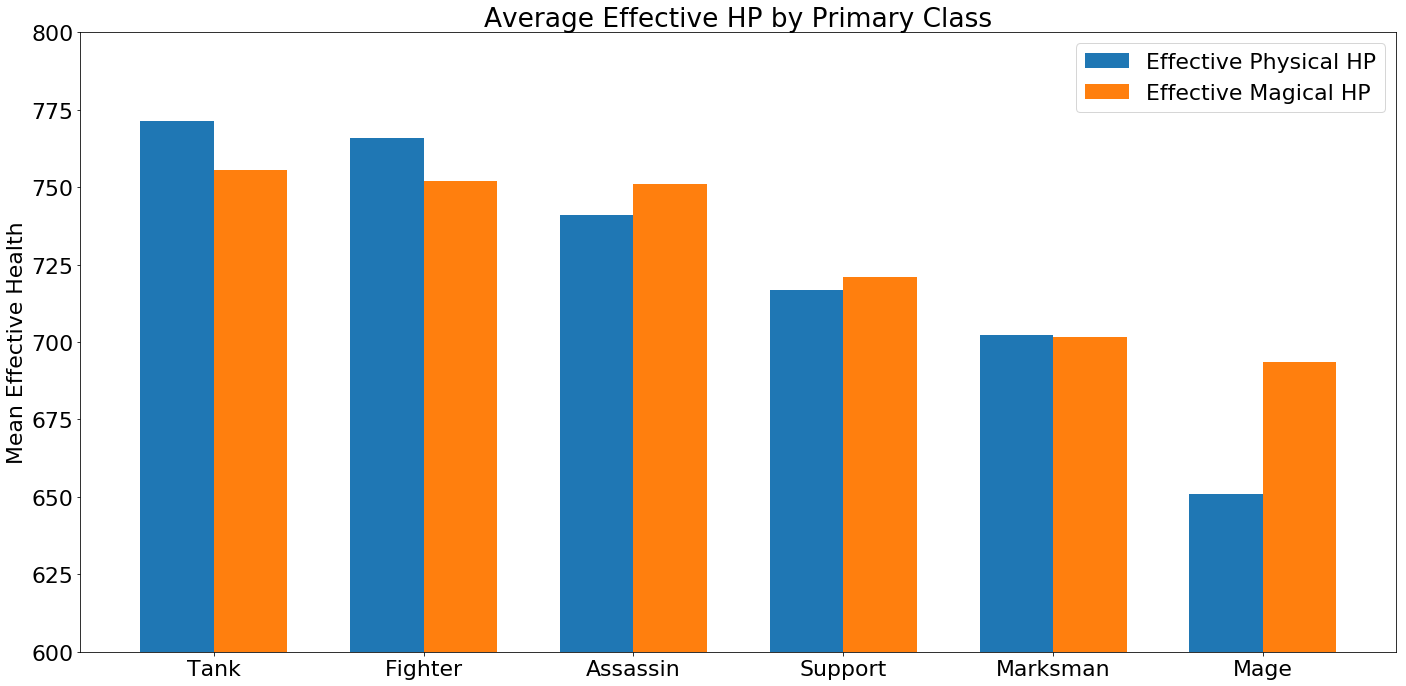

In [25]:
# Bar graph of effective hp

lvl1_effadhp = class_stats['Effective AD HP'].sort_values(ascending=False)
lvl1_effaphp = class_stats['Effective AP HP'].sort_values(ascending=False)
labels = class_stats['Effective AD HP'].sort_values(ascending=False).index

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
plt.rc('font', size=22) 
rects1 = ax.bar(x - width/2, lvl1_effadhp, width, label='Effective Physical HP')
rects2 = ax.bar(x + width/2, lvl1_effaphp, width, label='Effective Magical HP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Effective Health')
title = 'Average Effective HP by Primary Class'
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(600,800)

fig.tight_layout()
plt.savefig(title, bbox_inches = 'tight')
plt.show()

## Damage Per Second

In [26]:
# Setting up dps

rows = []
for prim_class in champ_stats['Primary Class'].unique():
    dps = (champ_stats['attackdamage']*champ_stats['attackspeed'])[champ_stats['Primary Class']==prim_class].mean()
    attack_range = champ_stats['attackrange'][champ_stats['Primary Class']==prim_class].mean()
    rows.append([dps, attack_range])
dps_stats = pd.DataFrame(rows, columns=['Damage Per Second', 'Attack Range'], index=champ_stats['Primary Class'].unique())
dps_stats['Attack Range'] = dps_stats['Attack Range']/10 # scaling to be easier to plot

No handles with labels found to put in legend.


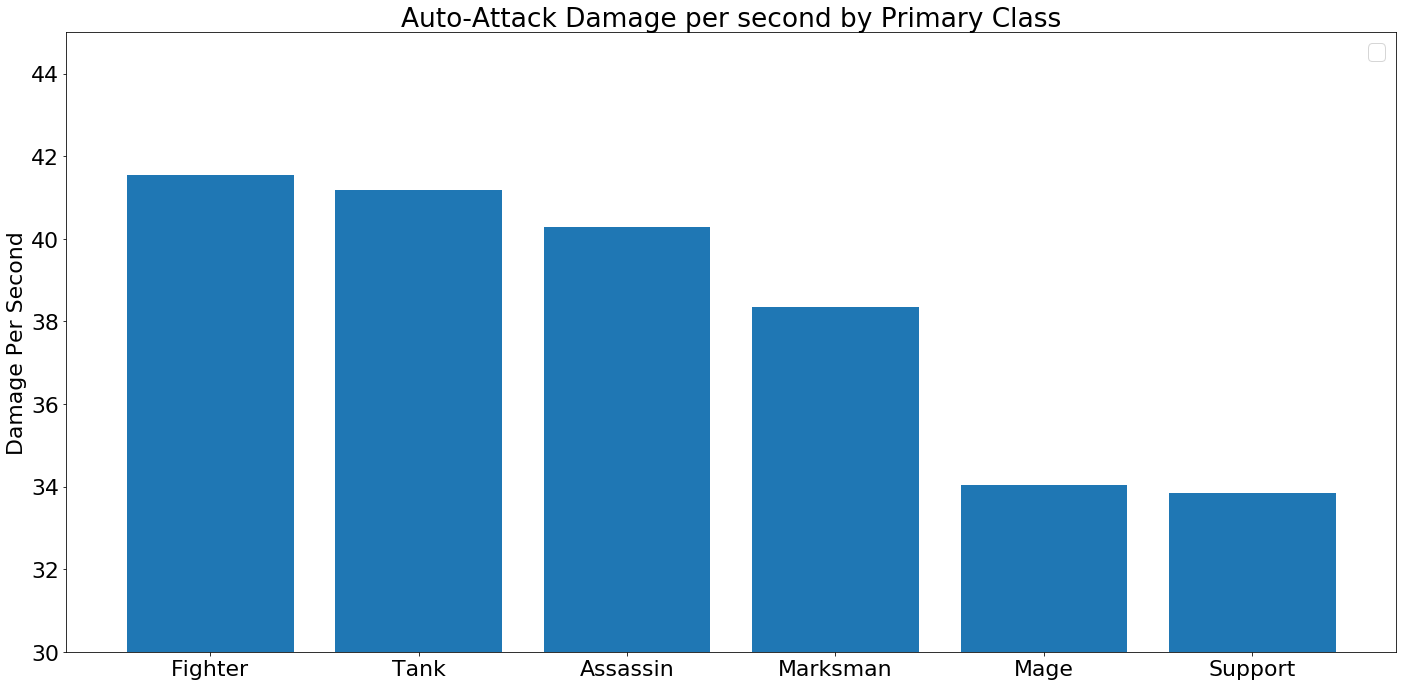

In [27]:
# damage per second bar graph on it's own
dps = dps_stats['Damage Per Second'].sort_values(ascending=False)
labels = dps_stats['Damage Per Second'].sort_values(ascending=False).index

fig = plt.figure(figsize=(20, 10))
plt.rc('font', size=22) 
plt.bar(labels, dps)

plt.ylabel('Damage Per Second')
title = 'Auto-Attack Damage per second by Primary Class'
plt.title(title)
plt.legend()
plt.ylim(30,45)

fig.tight_layout()
plt.savefig(title, bbox_inches = 'tight')
plt.show()

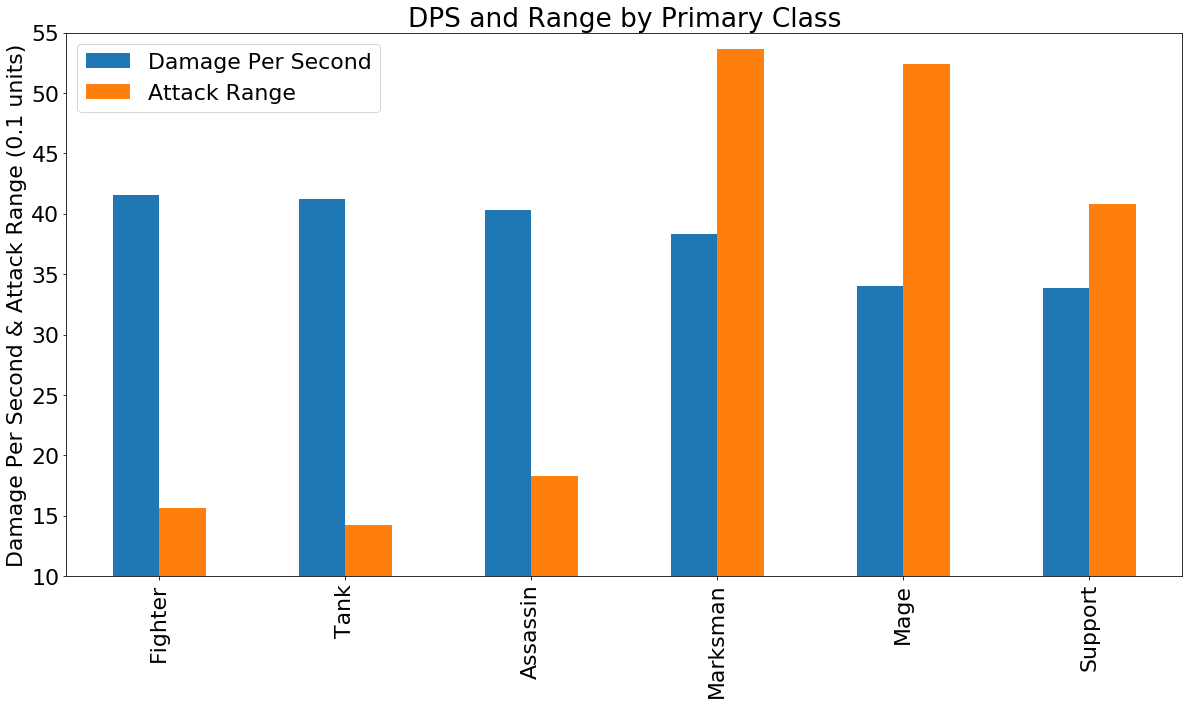

In [62]:
# damage per second and attack range for each class plotted 

dps_stats.sort_values(by=['Damage Per Second'], ascending=False, inplace=True)

plt.rc('font', size=22) 
# plt.bar(labels, dps_stats)
dps_stats.plot.bar(figsize=(20, 10))

plt.ylabel('Damage Per Second & Attack Range (0.1 units)')
title = 'DPS and Range by Primary Class'
plt.title(title)
plt.legend()
plt.ylim(10,55) #limiting for easier viewing of dps and to help tell the story of melee vs range

fig.tight_layout()
plt.savefig(title, bbox_inches = 'tight')
plt.show()

# PCA

In [29]:
# preprocessing, pca, tsne, and kmeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [30]:
# list of all the basic features we want to use
features = ['hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor',
       'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange',
       'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit',
       'critperlevel', 'attackdamage', 'attackdamageperlevel',
       'attackspeedperlevel', 'attackspeed']
x = champ_stats.loc[:, features]
# add in one hot encoded partype for mana and manaless
partype_df = pd.get_dummies(champ_stats['partype'])
x = pd.concat([x, partype_df], axis=1)
y = champ_stats.index

In [31]:
# standardizing the features
x_minmax = MinMaxScaler().fit_transform(x)

# 2d pca
pca = PCA(n_components = 2)
principal_components_minmax = pca.fit_transform(x_minmax)

In [32]:
# inputting into df for plotting
pca_df = pd.DataFrame(data = principal_components_minmax, 
                           columns = ['principal component 1', 'principal component 2'])

# recombining champion names and components
final_df = pd.concat([pca_df,pd.DataFrame(y)], axis = 1)
final_df.rename(columns={0: 'name'},inplace=True)

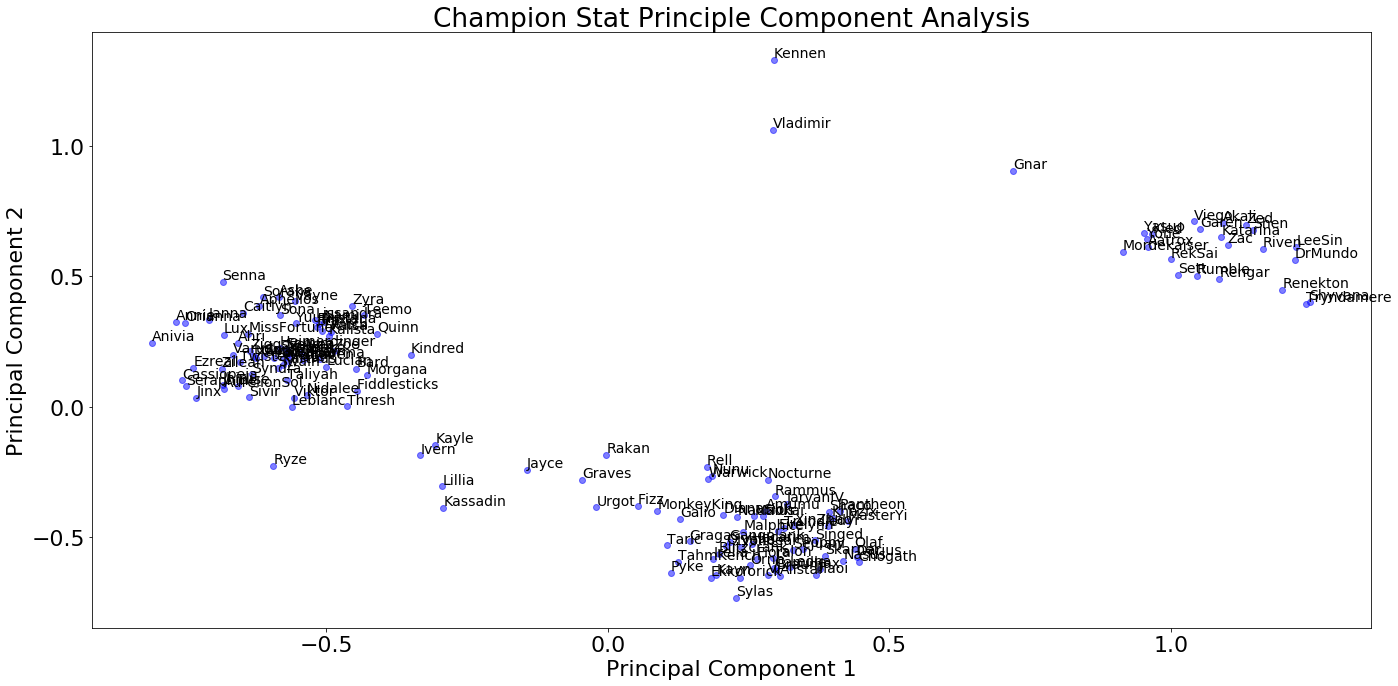

In [33]:
# Plot the results of the PCA

fig, ax = plt.subplots(figsize = (20, 10))

for i, key in enumerate(final_df['name']):
    # instantiates each x and y coordinate
    x_axis = pca_df['principal component 1'][i]
    y_axis = pca_df['principal component 2'][i]
    ax.scatter(x_axis, y_axis, marker = 'o', color = 'blue', alpha=0.5)
    # adding name to each point
    ax.text(x_axis, y_axis + 0.01, key, fontsize = 14)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
title = 'Champion Stat Principle Component Analysis'
plt.title(title)

fig.tight_layout()
plt.savefig(title, bbox_inches = 'tight')
plt.show()

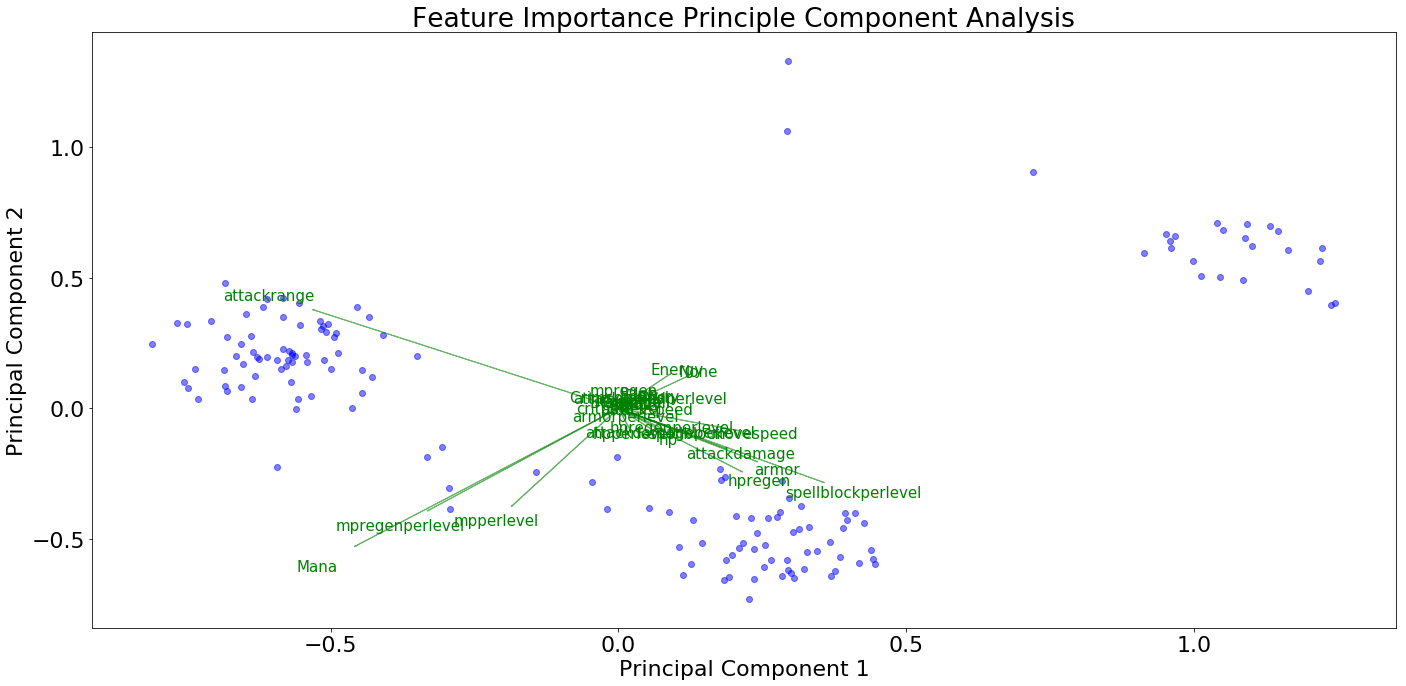

In [34]:
# plotting the relative magnitude of each feature (ie importance)
fig, ax = plt.subplots(figsize = (20, 10))

# mapping out each feature with coeff
coeff = np.transpose(pca.components_[0:2, :])
x_axis = principal_components_minmax[:, 0]
y_axis = principal_components_minmax[:, 1]
n = coeff.shape[0]

# list of labels for different features
labels = list(x.columns)

# plotting points
ax.scatter(x_axis, y_axis, marker = 'o', color = 'blue', alpha=0.5)

# labels each arrow with appropriate feature
for i in range(n):
    ax.arrow(0, 0, coeff[i, 0], coeff[i, 1],color = 'green', alpha = 0.5)
    ax.text(coeff[i, 0]* 1.15, coeff[i, 1] * 1.15, labels[i], color = 'green', ha = 'center', va = 'center', size = 15)
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
title = 'Feature Importance Principle Component Analysis'
plt.title(title)

fig.tight_layout()
plt.savefig(title, bbox_inches = 'tight')
plt.show()

It seems the three groups are at the top right, champions that don't use mana, at the bottom middle melee champions that use mana, and the left grouping being mana using ranged champions.

# Logistic Regression for Classification

In [35]:
# evaluate multinomial logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

model = LogisticRegression()
# fit the model on the whole dataset
X = x.values
y = champ_stats['Primary Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 5)

model.fit(X_train, y_train)
preds = model.predict(X_test)

confusion_matrix(y_test, preds)

C:\Users\lm5571\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lm5571\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([[ 0,  2,  0,  0,  1,  0],
       [ 1,  8,  0,  0,  0,  3],
       [ 0,  0, 11,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0],
       [ 0,  1,  1,  0,  4,  0],
       [ 3,  3,  0,  0,  1,  0]], dtype=int64)

In [36]:
confmtrx = np.array(confusion_matrix(y_test, preds))
class_array = np.sort(y.unique())
df_cm = pd.DataFrame(confmtrx, index=class_array, columns='Predicted ' + class_array)

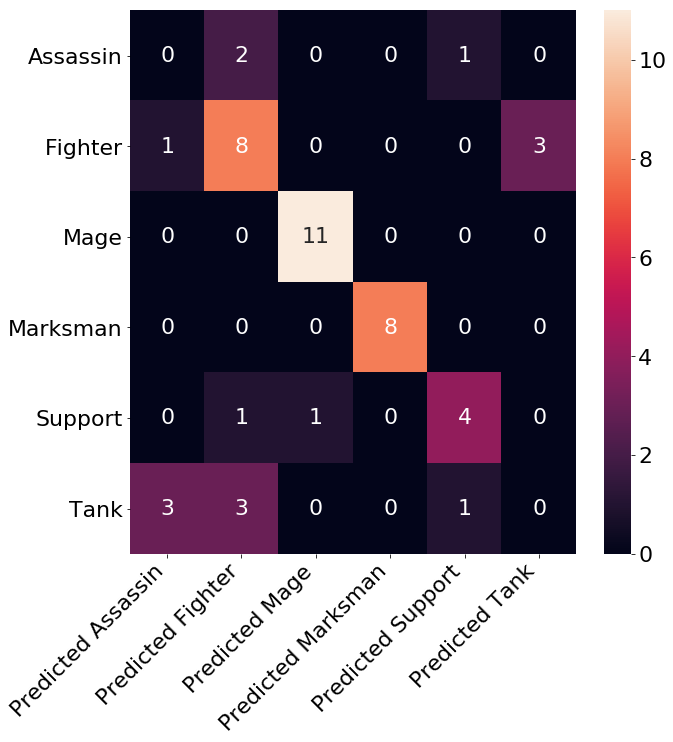

In [37]:
# Plot the confusion matrix
import seaborn as sn
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.savefig('Class Prediction Confusion Matrix Heatmap')

In [38]:
#Print the accuracy score of the logistic regression
print('Accuracy Score:', round(accuracy_score(y_test, preds),4)*100, '%')  

#Create classification report
class_report=classification_report(y_test, preds)
print(class_report)

Accuracy Score: 65.96 %
              precision    recall  f1-score   support

    Assassin       0.00      0.00      0.00         3
     Fighter       0.57      0.67      0.62        12
        Mage       0.92      1.00      0.96        11
    Marksman       1.00      1.00      1.00         8
     Support       0.67      0.67      0.67         6
        Tank       0.00      0.00      0.00         7

    accuracy                           0.66        47
   macro avg       0.53      0.56      0.54        47
weighted avg       0.62      0.66      0.64        47



### That's All Folks!